## Семинар 2 "Распознавание рукописных цифр"

ФИО: Слепцов Александр Аркадьевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [57]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
from torch.utils.data import ConcatDataset
from skimage.transform import rotate
from skimage.util import random_noise
%matplotlib inline

In [11]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

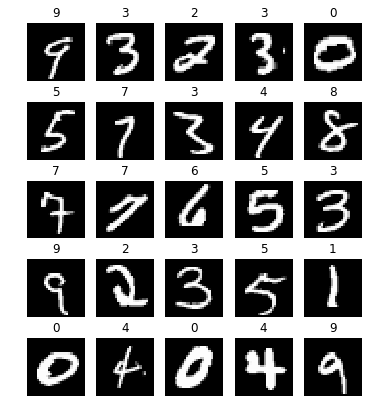

In [13]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [14]:
#network - наша сетка
def train(network, epochs, learning_rate, plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = [] 
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy() #вытягиваем в строчку
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True) #стирает выход ячейки
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [15]:
network_sig = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.300/0.294	Accuracy: 0.921/0.921

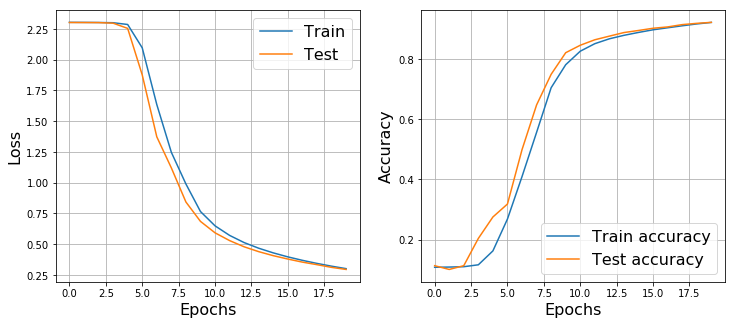

In [16]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network_sig, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [17]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0) #поэлементный

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = (self.X >= 0).astype(float)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [18]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.084	Accuracy: 0.990/0.975

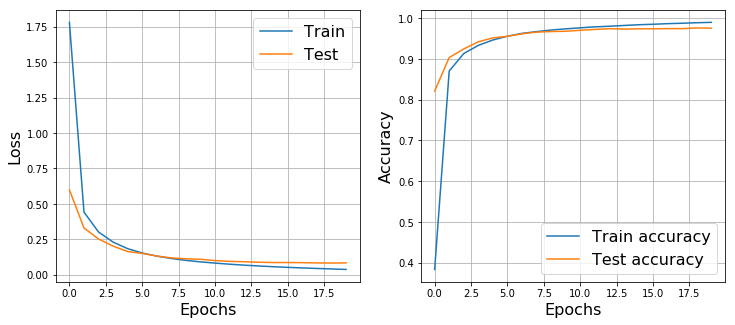

In [19]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.048/0.080	Accuracy: 0.986/0.976

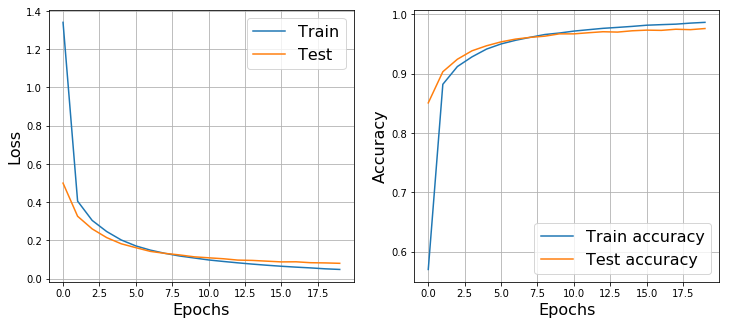

In [20]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

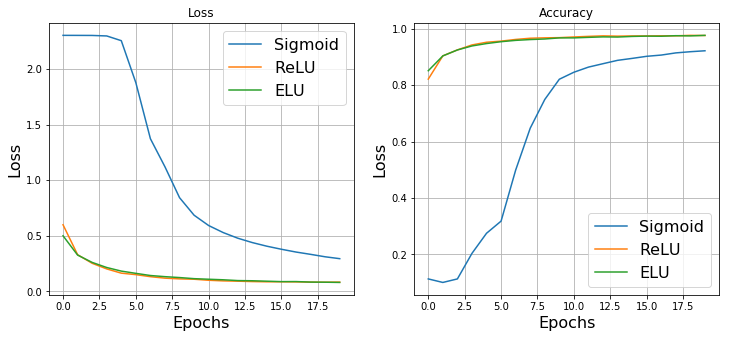

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

In [22]:
X = np.array([[1, 2], [3, 4]])
(np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

array([[0.76159416, 0.96402758],
       [0.99505475, 0.9993293 ]])

### HW1 (1 балл): Реализовать Tanh

In [23]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = 4. / ((np.exp(X) + (np.exp(-X))) ** 2)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.031/0.077	Accuracy: 0.993/0.977

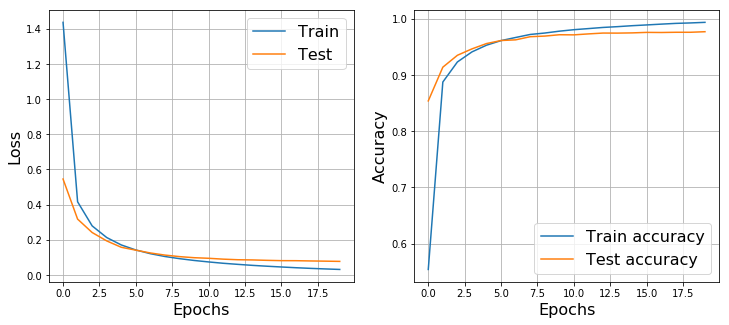

In [24]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_tan, ts_tan, tr_ac_tan, ts_ac_tan = train(network, 20, 0.01, plot=True, verbose=True)

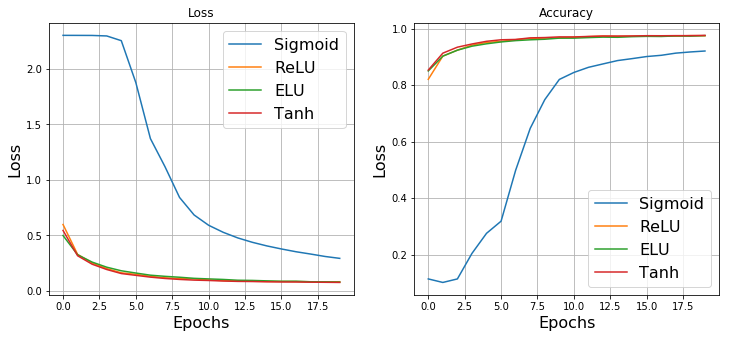

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_tan, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_tan, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [26]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

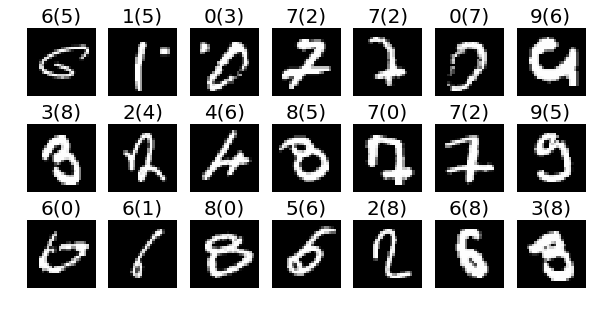

In [27]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [77]:
from skimage.transform import rotate

In [78]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

In [79]:
def rotate_all(arr):
    return rotate(arr, 30 * np.random.random_sample() - 15)

def shift_all(arr):
    return np.roll(arr, int(14 * np.random.random_sample() - 7))

def noise_all(arr):
    return random_noise(arr)

def rsn_all(arr):
    return rotate_all(noise_all(shift_all(arr)))
        

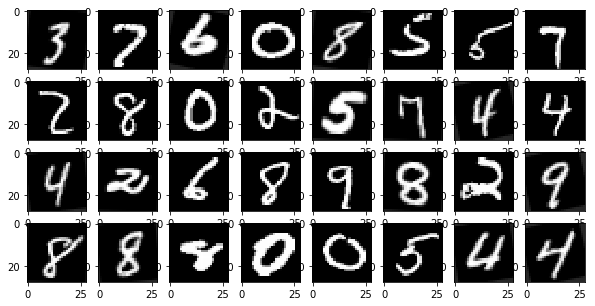

In [90]:
plt.figure(figsize=(10, 5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)

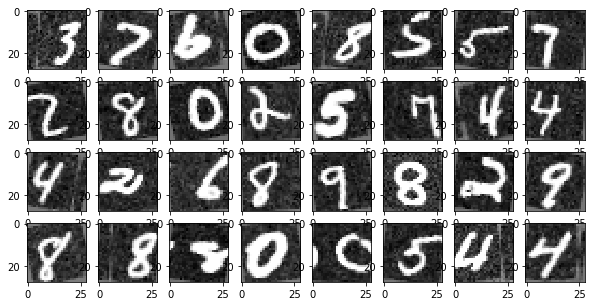

In [94]:
plt.figure(figsize=(10, 5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(rsn_all(X[i].reshape(28, 28).astype(float)), cmap=plt.cm.Greys_r)

In [95]:
def transform_add_dim(img_lab):
    return img_lab.view(1, 28, 28).float()

def transform_remove_dim(img_lab):
    return img_lab[0]

def transform_rotate(img_lab):
    return torch.from_numpy(rotate_all(img_lab.numpy().reshape(28, 28).astype(np.float)))

def transform_shift(img_lab):
    return torch.from_numpy(shift_all(img_lab.numpy().reshape(28, 28).astype(np.float)))

def transform_noise(img_lab):
    return torch.from_numpy(noise_all(img_lab.numpy().reshape(28, 28).astype(np.float)))

def transform_rsn(img_lab):
    return torch.from_numpy(rsn_all(img_lab.numpy().reshape(28, 28).astype(np.float)))

In [96]:
base_transforms = [transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    transform_remove_dim]

composed_rotate = transforms.Compose(base_transforms + [transform_rotate,
                                                  transform_add_dim])

composed_shift = transforms.Compose(base_transforms + [transform_shift,
                                                  transform_add_dim])

composed_noise = transforms.Compose(base_transforms + [transform_noise,
                                                  transform_add_dim])

composed_rsn = transforms.Compose(base_transforms + [transform_rsn,
                                                  transform_add_dim])

transforms_pair = [(None, "None"), (composed_rotate, "r"), (composed_shift, "s"), (composed_noise, "n"), (composed_rsn, "rsn")]

ReLU

In [97]:
res_composed = []
for c_transform, label in transforms_pair:
    if c_transform is not None:
        augm_dataset = MNIST('.', train=True, download=True, transform=c_transform)
        train_loader = DataLoader(ConcatDataset([train_dataset, augm_dataset]), 
                               batch_size=32, shuffle=True)
    
    network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
    loss = NLLLoss()
    
    tr_h, ts_h, tr_ac_h, ts_ac_h = train(network, 20, 0.01, plot=False, verbose=False)
    res_composed.append([tr_h, ts_h, tr_ac_h, ts_ac_h, label])

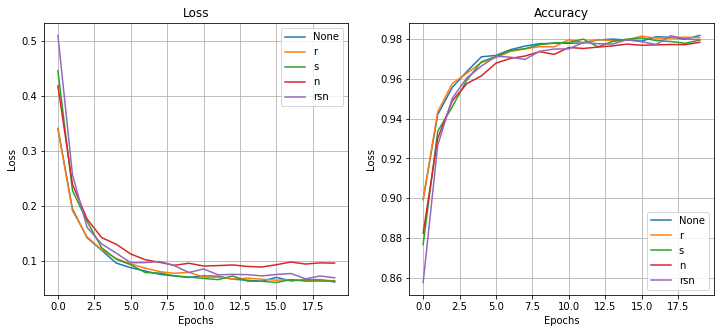

In [104]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
for slc in res_composed:
    plt.plot(slc[1], label=slc[4])
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(loc=0, fontsize=10)
plt.grid()
plt.subplot(1, 2, 2)

plt.title('Accuracy')
for slc in res_composed:
    plt.plot(slc[3], label=slc[4])
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(loc=0, fontsize=10)
plt.grid()
plt.show()

Tanh

In [100]:
res_composed_tan = []
for c_transform, label in transforms_pair:
    if c_transform is not None:
        augm_dataset = MNIST('.', train=True, download=True, transform=c_transform)
        train_loader = DataLoader(ConcatDataset([train_dataset, augm_dataset]), 
                               batch_size=32, shuffle=True)
    
    network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
    loss = NLLLoss()
    
    tr_h, ts_h, tr_ac_h, ts_ac_h = train(network, 20, 0.01, plot=False, verbose=False)
    res_composed_tan.append([tr_h, ts_h, tr_ac_h, ts_ac_h, label])

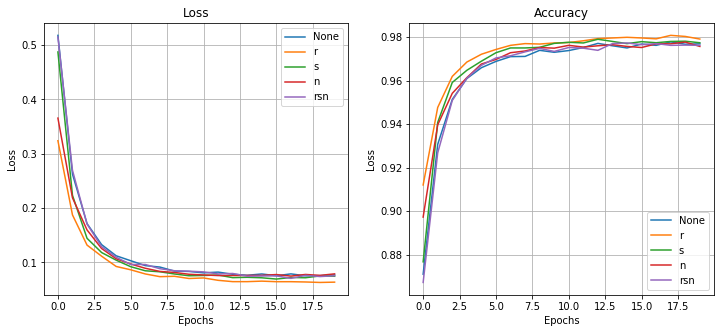

In [105]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')

for slc in res_composed_tan:
    plt.plot(slc[1], label=slc[4])
    
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(loc=0, fontsize=10)
plt.grid()
plt.subplot(1, 2, 2)

plt.title('Accuracy')

for slc in res_composed_tan:
    plt.plot(slc[3], label=slc[4])

plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(loc=0, fontsize=10)

plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Сигмоида дала наихудший результат. Наилучший - Tanh. Однако, та же ReLU дала результат не сильно хуже гиперболического тангенса, при этом не требует дорогой операции возведения в степень. Этим и объясняется её частота использования.

Почти во всех случаях аугментация данных MNIST-датасета либо не изменила скорость сходимости, либо слегка ее замедлила. Аналогичная ситуация с итоговым качеством. Только на графике с гиперболическим тангенсом заметен небольшой рост скорости сходимости при случайных поворотах картинок.